In [1]:
import numpy as np

import matplotlib.pyplot as plt 

from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
from keras.optimizers import Adam
from keras.models import Model
from keras.datasets import cifar10

%matplotlib inline

In [2]:
(cifar_train,_), (cifar_test,_) = cifar10.load_data()

size = 32
channel = 3

"""Rescaling Data"""
cifar_train = cifar_train/255
cifar_test = cifar_test/255

"""Noise -> mean = 0 ,standard deviation = 0.3"""
cifar_train_noise = cifar_train + 0.3* np.random.normal(0,0.3,size = cifar_train.shape)
cifar_test_noise = cifar_test + 0.3*np.random.normal(0,0.3,size = cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise,0,1)
cifar_test_noise = np.clip(cifar_test_noise,0,1)

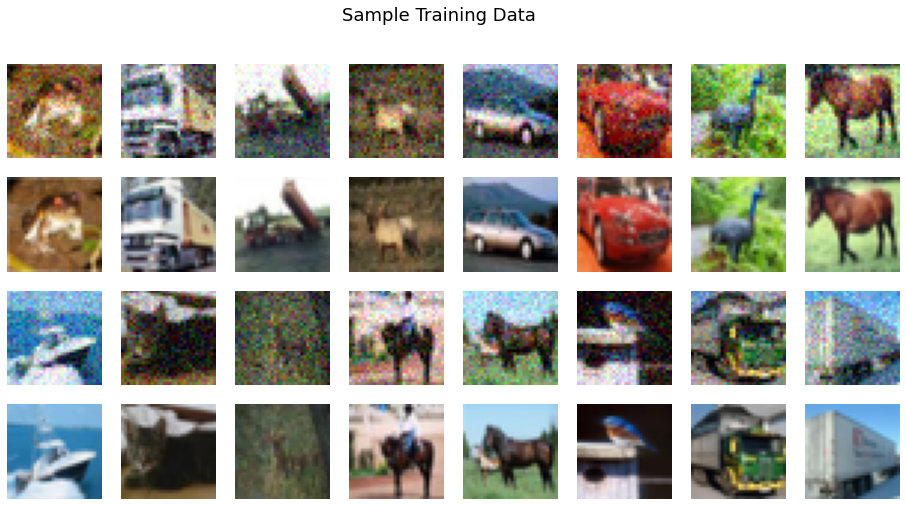

In [3]:
"""Plotting a few sample images along with the noisy images"""

rows = 2 
cols = 8 

f = plt.figure(figsize=(2*cols,2*rows*2)) 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) 
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) 
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
#plt.savefig("Cifar-trian.png")

plt.show()


In [4]:
"""Encoder Net""" 
inputs = Input(shape=(size,size,channel))

S = Conv2D(32, 3, activation='relu', padding='same')(inputs)
S = BatchNormalization()(S)
S = MaxPool2D()(S)
S = Dropout(0.5)(S)
"""Skip Connection"""
skip = Conv2D(32, 3, padding='same')(S)
S= LeakyReLU()(skip)
S= BatchNormalization()(S)
S = MaxPool2D()(S)
S = Dropout(0.5)(S)
S = Conv2D(64, 3, activation='relu', padding='same')(S)
S = BatchNormalization()(S)
encoded = MaxPool2D()(S)

"""Decoder Net"""
S = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
S = BatchNormalization()(S)
S = Dropout(0.5)(S)
S = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(S)
S = BatchNormalization()(S)
S = Dropout(0.5)(S)
S = Conv2DTranspose(32, 3, padding='same')(S)
"""Adding the skip connection"""
S = add([S,skip]) 
S = LeakyReLU()(S)
S = BatchNormalization()(S)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(S)

"""Auto Encoder Composing the encoder net and the decoder net"""
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
autoencoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

/home/user/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [5]:
"""Training...!"""
epochs = 25
batch_size = 256

hist = autoencoder.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test)
               )

Epoch 1/25
196/196 [==============================] - 99s 407ms/step - loss: 0.6112 - val_loss: 0.6092
Epoch 2/25
196/196 [==============================] - 77s 394ms/step - loss: 0.5631 - val_loss: 0.5757
Epoch 3/25
196/196 [==============================] - 76s 388ms/step - loss: 0.5607 - val_loss: 0.5615
Epoch 4/25
196/196 [==============================] - 77s 393ms/step - loss: 0.5600 - val_loss: 0.5592
Epoch 5/25
196/196 [==============================] - 77s 394ms/step - loss: 0.5588 - val_loss: 0.5582
Epoch 6/25
196/196 [==============================] - 76s 390ms/step - loss: 0.5586 - val_loss: 0.5567
Epoch 7/25
196/196 [==============================] - 76s 386ms/step - loss: 0.5583 - val_loss: 0.5564
Epoch 8/25
196/196 [==============================] - 76s 389ms/step - loss: 0.5578 - val_loss: 0.5561
Epoch 9/25
196/196 [==============================] - 75s 383ms/step - loss: 0.5574 - val_loss: 0.5560
Epoch 10/25
196/196 [==============================] - 75s 380ms/step - l

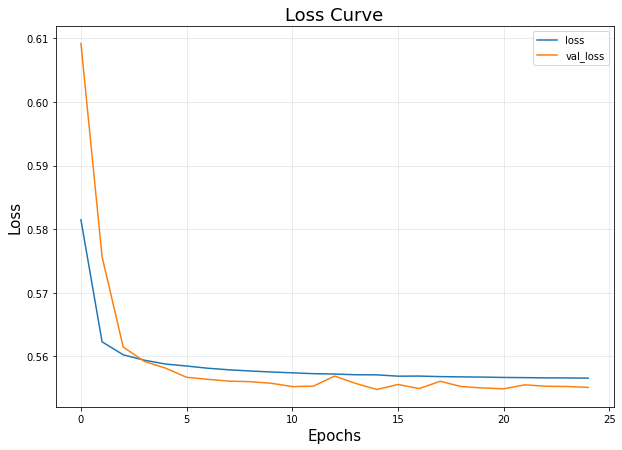

In [7]:
"""Plotting Loss"""
L = plt.figure(figsize=(10,7))
L.add_subplot()
plt.plot(hist.epoch, hist.history['loss'], label = "loss") # Loss curve for training set
plt.plot(hist.epoch, hist.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [8]:
num_imgs = 48
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] 
cifar_test_denoised = autoencoder.predict(cifar_test_images) 

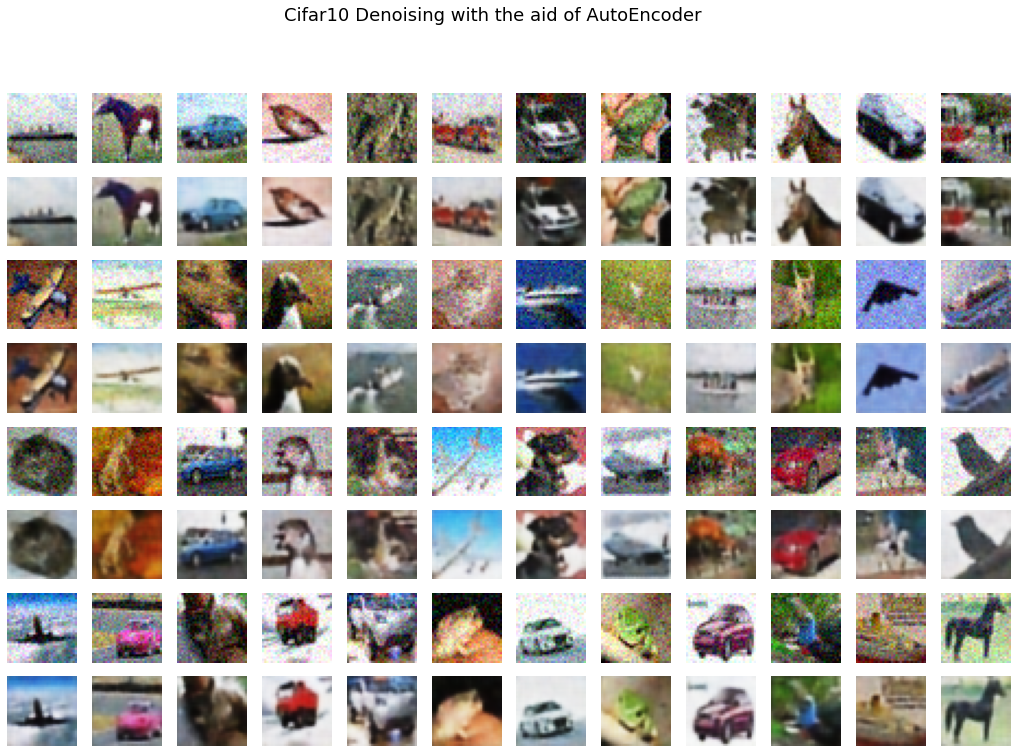

In [11]:
"""Image Denoised"""
rows = 4 
cols = 12 
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2))
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) 
        plt.imshow(cifar_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) 
        plt.imshow(cifar_test_denoised[i*cols + j]) 
        plt.axis("off")

f.suptitle("Cifar10 Denoising with the aid of AutoEncoder",fontsize=18)
#plt.savefig("test_results_cifar10.png")

plt.show()